In [1]:
import numpy as np
import pandas as pd
import gc

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split, PredefinedSplit
from sklearn.metrics import f1_score, make_scorer, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from joblib import dump, load
from scipy.sparse import csr_matrix
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

First, we are going to perform one-hot encoding on the categorical features. Then we are going to try grid search with the numerical features left as they are and then normalized using StandardScaler.

In [2]:
X_train = pd.read_csv("../data/X_train.csv", index_col = 0)
y_train = pd.read_csv("../data/y_train.csv", index_col = 0)

X_test = pd.read_csv("../data/X_test.csv", index_col = 0)
y_test = pd.read_csv("../data/y_test.csv", index_col = 0)

In [3]:
categorical_features = ["day_of_week", "first_road_class", "road_type", "junction_detail", 
                   "second_road_class", "pedestrian_crossing_human_control", 
                   "pedestrian_crossing_physical_facilities", "light_conditions", "weather_conditions",
                   "road_surface_conditions", "special_conditions_at_site", "carriageway_hazards",
                   "did_police_officer_attend_scene_of_accident", "vehicle_type", "towing_and_articulation",
                   "vehicle_manoeuvre", "vehicle_location_restricted_lane", "junction_location",
                   "skidding_and_overturning", "hit_object_in_carriageway", "hit_object_off_carriageway",
                   "vehicle_leaving_carriageway", "first_point_of_impact", "sex_of_driver", "vehicle_left_hand_drive",
                   "journey_purpose_of_driver", "casualty_class", "sex_of_casualty", 
                   "pedestrian_location", "pedestrian_movement", "car_passenger", "bus_or_coach_passenger",
                   "pedestrian_road_maintenance_worker", "vehicle_direction_from", "vehicle_direction_to",
                   "age_band_of_casualty", "day_of_month", "month", "time_rounded",
                   "escooter_flag"]

In [4]:
numerical_features = [feature for feature in X_train.columns if feature not in categorical_features]

In [5]:
ohe = OneHotEncoder(dtype = np.int8, sparse_output = False)

In [6]:
def perform_ohe(df):
    for col in categorical_features:
        df[col] = df[col].astype(str)

    ohe_transformed = ohe.fit_transform(df[categorical_features])
    df_ohe = pd.DataFrame(data = ohe_transformed, columns = ohe.get_feature_names_out(categorical_features))

    df_num_values = df.select_dtypes(include=["int64", "float64"]).reset_index(drop = True)

    df = pd.merge(df_ohe.reset_index(), df_num_values.reset_index())

    return df

In [7]:
X_train = perform_ohe(X_train)
X_test = perform_ohe(X_test)

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [9]:
validation_fold = np.array([-1] * len(X_train) + [0] * len(X_val))

In [10]:
X_combined = csr_matrix(np.vstack((X_train, X_val)))
y_combined = np.concatenate((y_train, y_val))

Deleting the dataframes we are no longer going to use in order to save some memory

In [14]:
dump(X_combined, "../data/X_train_for_logistic_regression.joblib")
dump(y_combined, "../data/y_train_for_logistic_regression.joblib")
dump(csr_matrix(X_test), "../data/X_test_for_logistic_regression.joblib")
dump(y_test, "../data/y_test_for_logistic_regression.joblib")


['y_test_for_logistic_regression.joblib']

In [10]:
del X_val
del X_train
del y_val
del y_train

gc.collect()

0

In [11]:
ps = PredefinedSplit(test_fold=validation_fold)

For the grid search, we are going to loop only through the values of "C"

In [12]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['saga'],
    'class_weight': ['balanced'],
}


In [13]:
log_reg= LogisticRegression(
    max_iter=8000,
)

In [14]:
scorer = make_scorer(f1_score, average='weighted')

In [15]:
grid_search = GridSearchCV(
    estimator=log_reg, 
    param_grid=param_grid, 
    scoring=scorer, 
    cv=ps, n_jobs=-1,
    verbose=4)

In [16]:
grid_search.fit(X_combined, np.ravel(y_combined))

Fitting 1 folds for each of 5 candidates, totalling 5 fits
[CV 1/1] END C=0.01, class_weight=balanced, penalty=l2, solver=saga;, score=0.574 total time=36.9min
[CV 1/1] END C=0.1, class_weight=balanced, penalty=l2, solver=saga;, score=0.580 total time=37.2min
[CV 1/1] END C=10, class_weight=balanced, penalty=l2, solver=saga;, score=0.607 total time=37.4min
[CV 1/1] END C=100, class_weight=balanced, penalty=l2, solver=saga;, score=0.482 total time=37.7min
[CV 1/1] END C=1, class_weight=balanced, penalty=l2, solver=saga;, score=0.541 total time=41.7min


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=LogisticRegression(max_iter=8000), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'class_weight': ['balanced'], 'penalty': ['l2'],
                         'solver': ['saga']},
             scoring=make_scorer(f1_score, response_method='predict', average=weighted),
             verbose=4)

The results don't look promising at all... Let's save the model anyway and look at the metrics:

In [22]:
dump(grid_search.best_estimator_, "../models/logistic_regression_best_result.joblib")

['logistic_regression_best_result.joblib']

In [23]:
model = grid_search.best_estimator_

In [26]:
y_pred = model.predict(csr_matrix(X_test))

In [28]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.04      0.69      0.08      2367
           2       0.25      0.10      0.14     25007
           3       0.80      0.60      0.69     84676

    accuracy                           0.49    112050
   macro avg       0.37      0.46      0.30    112050
weighted avg       0.66      0.49      0.55    112050



In [30]:
model.score(X_test, y_test)

/home/gecata/.local/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


0.4910397144132084

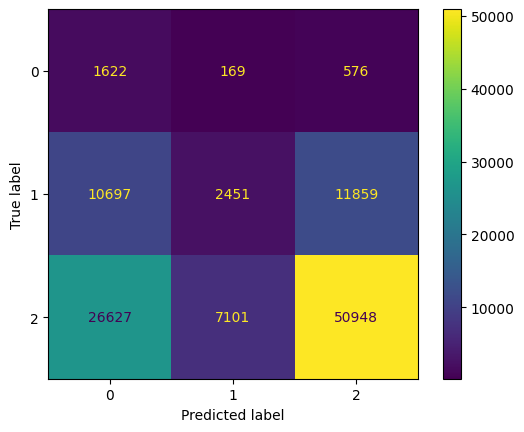

In [37]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()

The results are far from satisfying, as expected from a simple model like the logistic regression. But let's first look at the results

In [ ]:
# new_log_reg = load("logistic_regression_8000_max_iter_100_C_balanced_class_weight_l2_penalty.joblib")

In [ ]:
# new_log_reg.predict(X_train)

In [95]:
preprocessor = ColumnTransformer(
    transformers=[
        ("scaler", StandardScaler(), numerical_features),
    ],
    remainder="passthrough"  # Leave other columns unchanged
)


In [96]:
pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),  # Step 1: Preprocessing
    ]
)

In [97]:
X_transformed

,scaler__accident_year,scaler__number_of_vehicles,scaler__number_of_casualties,scaler__speed_limit,scaler__age_of_driver,scaler__engine_capacity_cc,scaler__age_of_vehicle,scaler__age_of_casualty,remainder__day_of_week,remainder__first_road_class,...,remainder__sex_of_casualty,remainder__age_band_of_casualty,remainder__pedestrian_location,remainder__pedestrian_movement,remainder__car_passenger,remainder__bus_or_coach_passenger,remainder__pedestrian_road_maintenance_worker,remainder__day_of_month,remainder__month,remainder__time_rounded
0,0.020334,0.099699,0.799558,-0.586976,0.349481,-0.11217,1.199888,0.434782,1,3,...,1,8.0,0,0,0,0,0,2,5,23
1,0.708676,-1.14939,-0.498586,-0.586976,1.99164,-0.185553,-0.244254,-1.243149,2,-1,...,1,3.0,1,1,0,0,-1,7,2,15
2,0.708676,0.099699,-0.498586,-0.586976,0.653584,-0.62505,-0.063736,0.696959,6,-1,...,1,8.0,0,0,0,0,0,25,2,7
3,1.397018,0.099699,-0.498586,-0.586976,-1.110216,-0.34508,1.560923,-0.823666,6,3,...,1,5.0,0,0,0,0,0,23,6,6
4,0.020334,-1.14939,-0.498586,-0.586976,0.531943,-0.224637,0.838852,-0.509054,6,-1,...,2,6.0,5,1,0,0,0,17,9,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
448195,0.020334,-1.14939,-0.498586,0.733495,-0.866934,-0.305198,0.658335,-0.613925,2,3,...,1,6.0,0,0,0,0,0,11,10,22
448196,0.020334,0.099699,-0.498586,-1.247212,-1.110216,0.523546,-0.063736,-0.823666,4,3,...,1,5.0,0,0,0,0,0,13,10,16
448197,-0.668008,0.099699,0.150486,-0.586976,1.14015,0.2691,-0.605289,1.116442,4,4,...,1,9.0,0,0,0,0,0,26,2,14
448198,1.397018,0.099699,-0.498586,0.733495,0.410301,-0.056336,0.477817,0.487217,2,3,...,2,8.0,0,0,0,0,0,22,5,7


In [99]:
pd.DataFrame(pipeline.transform(X_train), columns = pipeline.named_steps["preprocessor"].get_feature_names_out())

,scaler__accident_year,scaler__number_of_vehicles,scaler__number_of_casualties,scaler__speed_limit,scaler__age_of_driver,scaler__engine_capacity_cc,scaler__age_of_vehicle,scaler__age_of_casualty,remainder__day_of_week,remainder__first_road_class,...,remainder__sex_of_casualty,remainder__age_band_of_casualty,remainder__pedestrian_location,remainder__pedestrian_movement,remainder__car_passenger,remainder__bus_or_coach_passenger,remainder__pedestrian_road_maintenance_worker,remainder__day_of_month,remainder__month,remainder__time_rounded
0,0.020140,1.352161,-0.494609,-0.587516,-0.623160,-0.025700,-0.965784,-0.404248,3.0,3.0,...,2.0,6.0,0.0,0.0,0.0,0.0,0.0,14.0,12.0,15.0
1,-1.356284,-1.151452,-0.494609,-0.587516,-0.927104,-0.056068,0.116020,-0.666381,5.0,-1.0,...,2.0,5.0,0.0,0.0,0.0,0.0,0.0,18.0,7.0,11.0
2,-1.356284,0.100355,1.434411,-0.587516,0.227883,0.212453,1.378125,0.329726,2.0,-1.0,...,2.0,7.0,0.0,0.0,0.0,0.0,0.0,24.0,6.0,21.0
3,0.020140,0.100355,0.148398,-0.587516,0.227883,-0.032093,0.116020,0.329726,3.0,5.0,...,1.0,7.0,0.0,0.0,0.0,0.0,0.0,13.0,4.0,15.0
4,-1.356284,0.100355,-0.494609,-0.587516,-0.076061,0.134933,0.476622,0.067593,1.0,-1.0,...,1.0,7.0,0.0,0.0,0.0,0.0,0.0,11.0,8.0,17.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358555,0.708352,1.352161,-0.494609,-0.587516,0.167094,-0.056068,-0.064280,0.277300,7.0,3.0,...,1.0,7.0,0.0,0.0,0.0,0.0,0.0,28.0,5.0,21.0
358556,0.708352,0.100355,1.434411,-0.587516,-0.258427,-0.310205,-0.064280,-0.142114,2.0,-1.0,...,2.0,6.0,0.0,0.0,1.0,0.0,0.0,28.0,11.0,12.0
358557,1.396564,2.603968,-0.494609,-0.587516,-1.231048,-0.824071,1.197824,-0.928515,4.0,3.0,...,1.0,4.0,0.0,0.0,0.0,0.0,0.0,12.0,4.0,12.0
358558,0.020140,-1.151452,0.791404,1.391564,-0.015272,-0.056068,0.656922,-0.456674,4.0,4.0,...,2.0,6.0,0.0,0.0,2.0,0.0,0.0,24.0,11.0,19.0


In [100]:
pipeline.fit(X_train)
X_transformed = pd.DataFrame(pipeline.transform(X_train), columns = pipeline.named_steps["preprocessor"].get_feature_names_out())
# X_transformed = perform_ohe(X_transformed)

feature_names = pipeline.named_steps["preprocessor"].get_feature_names_out()

X_train = pd.DataFrame(X_transformed, columns=feature_names)

In [101]:
log_reg_scaled = LogisticRegression(max_iter = 8000)

In [73]:
grid_search = GridSearchCV(
    estimator=log_reg_scaled, 
    param_grid=param_grid, 
    scoring=scorer, 
    cv=ps, n_jobs=-1,
    verbose=4)

In [67]:
grid_search.fit(X_train, np.ravel(y_combined))

Fitting 1 folds for each of 5 candidates, totalling 5 fits


/home/gecata/.local/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/gecata/.local/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/gecata/.local/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/gecata/.local/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/gecata/.local/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/1] END C=0.01, class_weight=balanced, penalty=l2, solver=saga;, score=0.224 total time=60.9min
[CV 1/1] END C=0.1, class_weight=balanced, penalty=l2, solver=saga;, score=0.203 total time=60.9min
[CV 1/1] END C=10, class_weight=balanced, penalty=l2, solver=saga;, score=0.299 total time=61.0min
[CV 1/1] END C=1, class_weight=balanced, penalty=l2, solver=saga;, score=0.201 total time=61.4min
[CV 1/1] END C=100, class_weight=balanced, penalty=l2, solver=saga;, score=0.391 total time=61.4min


/home/gecata/.local/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=LogisticRegression(max_iter=8000), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'class_weight': ['balanced'], 'penalty': ['l2'],
                         'solver': ['saga']},
             scoring=make_scorer(f1_score, response_method='predict', average=weighted),
             verbose=4)

Here the scores became even lower, so we will stick to the non-standardized features.